# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports (pip)

In [2]:
!pip install wntr
!pip install scipy
!pip install tqdm
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from collections import Counter

     |████████████████████████████████| 4.4 MB 4.5 MB/s 


### Imports (self)

In [3]:
import utils
import models

from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator
from models.Regression import RegressionModel
from models.RegressionEnsamble import RegressionEnsamble
from models.Classification import ClassificationModel
from models.OutlierDetection import OutlierDetectionModel

from utils.helper import any_transform
from utils.helper import shuffle_data
from utils.metrics import print_metrics
from utils.feature_extraction import past_days_transform

import importlib
importlib.reload(utils.helper)
importlib.reload(utils.metrics)
importlib.reload(utils.feature_extraction)
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)
importlib.reload(models.Regression)
importlib.reload(models.RegressionEnsamble)
importlib.reload(models.Classification)
importlib.reload(models.OutlierDetection)

<module 'models.OutlierDetection' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/models/OutlierDetection.py'>

### LeakDB Dataset

In [4]:
!cp ../Net1_CMH.zip ../../../../
!unzip ../../../../Net1_CMH.zip -d ../../../../

LEAKDB_PATH = '../../../../Net1_CMH/'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_10.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_11.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_110.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_111.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_112.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_113.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_12.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_121.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_122.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_21.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_22.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_31.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Flows/Link_9.csv  
  inflating: ../../../../Net1_CMH/Scenario-902/Labels.csv

### Plotting

In [5]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

## Data Generation

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


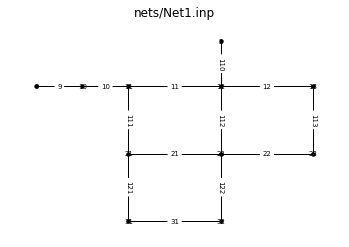

In [6]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

In [ ]:
X_sim, y_sim, y_sim_nodes = gen.gen_dataset(size=50*6*2, leakage_nodes=wdn.important_nodes, shuffle=True, return_nodes=True)
Counter(y_sim_nodes)

Generating 300 leakage scenarios...


100%|██████████| 300/300 [07:11<00:00,  1.44s/it]


Generating 300 non leakage scenarios...


100%|██████████| 300/300 [07:55<00:00,  1.58s/it]


Counter({'': 300,
         '10': 35,
         '11': 30,
         '12': 33,
         '13': 39,
         '21': 30,
         '22': 36,
         '23': 25,
         '31': 33,
         '32': 39})

In [ ]:
X_db, y_db = gen.get_dataset(LEAKDB_PATH, 600, days_per_sim=20)
Counter(any_transform(y_db, y_db)[0])

100%|██████████| 600/600 [00:48<00:00, 12.42it/s]


Counter({0: 433, 1: 167})

In [7]:
X_db_full, y_db_full = gen.get_full_dataset(LEAKDB_PATH)
Counter(any_transform(y_db_full, y_db_full)[0])

100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


Counter({0: 266, 1: 734})

In [ ]:
X, y = X_sim, y_sim

In [ ]:
X, y = X_db, y_db

In [8]:
X, y = X_db_full, y_db_full

## Testing


### Der Train-Test-Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({1: 564, 0: 186})
Counter({1: 170, 0: 80})


In [ ]:
### SIMULATION

from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = ClassificationModel(KNeighborsClassifier(), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

# Show metric results
print_metrics(y_test, y_pred)

[[81  0]
 [ 0 69]]
Accuracy:     1.0	Wie oft lag der Algorithmus richtig?
Recall (Sns): 1.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 0.551ts	Std: 1.518ts	Median: 0.0ts


In [ ]:
### LEAKDB SELECTION

from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = ClassificationModel(KNeighborsClassifier(), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

# Show metric results
print_metrics(y_test, y_pred)

[[82 29]
 [ 1 38]]
Accuracy:     0.8	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.974	Wie gut wurden echte Lecks erkannt?
Specificity:  0.739	Wie gut wurde 'alles ok' erkannt?
Precision:    0.567	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 3.447ts	Std: 15.541ts	Median: 0.0ts


In [ ]:
### LEAKDB FULL

from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = ClassificationModel(KNeighborsClassifier(), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test, verbose=True)

# Show metric results
print_metrics(y_test, y_pred)

100%|██████████| 250/250 [20:12<00:00,  4.85s/it]


[[ 26  54]
 [  1 169]]
Accuracy:     0.78	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.994	Wie gut wurden echte Lecks erkannt?
Specificity:  0.325	Wie gut wurde 'alles ok' erkannt?
Precision:    0.758	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 12.096ts	Std: 103.082ts	Median: 0.0ts


Ergebnis: Classification


```
Accuracy:     0.78	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.994	Wie gut wurden echte Lecks erkannt?
Specificity:  0.325	Wie gut wurde 'alles ok' erkannt?
Precision:    0.758	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 12.096ts	Std: 103.082ts	Median: 0.0ts
```



Ergebnis: RegrEns

```
Accuracy:     0.952	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.989	Wie gut wurden echte Lecks erkannt?
Specificity:  0.868	Wie gut wurde 'alles ok' erkannt?
Precision:    0.945	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 116.0ts	Std: 1068.845ts	Median: 0.0ts
```



### Das Grid-Search

In [ ]:
for _ in range(500):
  i = np.random.randint(len(X))
  del X[i]
  del y[i]

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time_mean, detection_time_std, detection_time_median
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time_mean': make_scorer(detection_time_mean),
           'detection_time_std': make_scorer(detection_time_std),
           'detection_time_median': make_scorer(detection_time_median)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time_mean', 'mean_test_detection_time_std', 'mean_test_detection_time_median',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
model_knn = ClassificationModel(KNeighborsClassifier())

grid = GridSearchCV(model_knn, parameters_knn, scoring=scoring, refit='detection_time_mean', cv=3, verbose=3)
grid.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END n_neighbors=3, weights=uniform; accuracy: (test=0.778) detection_time_mean: (test=2.242) detection_time_median: (test=0.000) detection_time_std: (test=7.274) precision: (test=0.766) recall: (test=1.000) specificity: (test=0.196) total time= 9.3min
[CV 2/3] END n_neighbors=3, weights=uniform; accuracy: (test=0.737) detection_time_mean: (test=2.388) detection_time_median: (test=0.000) detection_time_std: (test=7.164) precision: (test=0.731) recall: (test=0.992) specificity: (test=0.122) total time= 9.0min
[CV 3/3] END n_neighbors=3, weights=uniform; accuracy: (test=0.843) detection_time_mean: (test=50.484) detection_time_median: (test=0.000) detection_time_std: (test=341.259) precision: (test=0.830) recall: (test=1.000) specificity: (test=0.333) total time= 8.7min
[CV 1/3] END n_neighbors=3, weights=distance; accuracy: (test=0.778) detection_time_mean: (test=2.242) detection_time_median: (test=0.000) detection_time_

GridSearchCV(cv=3,
             estimator=ClassificationModel(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None,
                                           model=KNeighborsClassifier(),
                                           n_jobs=None, n_neighbors=5, p=2,
                                           weights='uniform'),
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             refit='detection_time_mean',
             scoring={'accuracy': make_scorer(accuracy),
                      'detection_time_mean': make_scorer(detection_time_mean),
                      'detection_time_median': make_scorer(detection_time_median),
                      'detection_time_std': make_scorer(detection_time_std),
                      'precision': make_scorer(precision),
                      'recall': make_scorer(recall),
  

In [ ]:
print(grid.best_params_)
results_knn = pd.DataFrame(grid.cv_results_)

results_knn[['param_n_neighbors', 'param_weights'] + important_results].sort_values('mean_test_accuracy', ascending=False)

{'n_neighbors': 9, 'weights': 'distance'}


,param_n_neighbors,param_weights,mean_test_accuracy,mean_test_detection_time_mean,mean_test_detection_time_std,mean_test_detection_time_median,mean_test_precision,mean_test_recall,mean_test_specificity
6,9,uniform,0.864079,34.748322,211.014966,0.0,0.848818,0.991926,0.523199
7,9,distance,0.864079,34.754069,211.015269,0.0,0.848818,0.991926,0.523199
4,7,uniform,0.852103,29.047756,196.268553,0.0,0.834038,0.997175,0.464401
5,7,distance,0.850107,29.047756,196.268553,0.0,0.832293,0.997175,0.457599
3,5,distance,0.824099,20.334544,111.101279,0.0,0.808172,0.997175,0.358667
2,5,uniform,0.822091,20.334544,111.101279,0.0,0.806252,0.997175,0.350120
0,3,uniform,0.786115,18.371242,118.565705,0.0,0.775713,0.997175,0.217145
1,3,distance,0.786115,18.371242,118.565705,0.0,0.775713,0.997175,0.217145


## Classification

### Der Train-Test-Split

Mit dem Train-Test-Split können wir 'overfitting' bei der Evaluation verhindern.

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({0: 1085, 1: 415})
Counter({0: 356, 1: 144})


Nun können wir den ersten Classifier, SVM, testen.

In [ ]:
from sklearn.svm import SVC

# Create the model
model = ClassificationModel(SVC(gamma=0.001), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

# Show metric results
print_metrics(y_test, y_pred)

[[77  0]
 [ 1 72]]
Accuracy:     0.993	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.986	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Stunden dauerte es bis zum erkennen?
 -> Mean: 4.333h	Std: 5.344h	Median: 2.0h


In [ ]:
# Display the pressure values
X_show = pd.DataFrame(X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2])))
y_pred_show = np.concatenate(y_pred)
y_true_show = np.concatenate(y_test)

show_data(X_show.loc[:, X_show.columns != 9], y_pred_show)

Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```


Testen wir jetzt verschiedene Modelle aus.

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time_mean, detection_time_std, detection_time_median
from tqdm import tqdm

metrics = [accuracy, recall, specificity, precision, detection_time_mean, detection_time_std, detection_time_median]
base_models = [SVC(gamma=0.001),
               KNeighborsClassifier(n_neighbors=5),
               MLPClassifier(hidden_layer_sizes=(18,10))]
results = {}

for base_model in tqdm(base_models):
  model = ClassificationModel(base_model, medfilt_kernel_size=5)
  y_pred = model.fit(X_train, y_train).predict(X_test)
  results[base_model] = [round(metric(y_test, y_pred), 3) for metric in metrics]

results = pd.DataFrame(results).T
results.columns = 'accuracy', 'recall', 'specificity', 'precision', 'detection_time', 'detection_time_std', 'detection_time_median'
results

100%|██████████| 3/3 [00:46<00:00, 15.40s/it]


,accuracy,recall,specificity,precision,detection_time,detection_time_std,detection_time_median
SVC(gamma=0.001),0.993,0.986,1.0,1.0,4.333,5.344,2.0
KNeighborsClassifier(),1.000,1.000,1.0,1.0,0.438,0.979,0.0
"MLPClassifier(hidden_layer_sizes=(18, 10))",0.847,0.685,1.0,1.0,3.740,6.997,1.0


In [ ]:
# Ergebniss, wenn nur '12' als Node Lecks hat. TODO: Testen, was am besten erkannt wird.

100%|██████████| 3/3 [00:35<00:00, 11.98s/it]


,accuracy,recall,specificity,precision,detection_time,detection_time_std,detection_time_median
SVC(gamma=0.001),1.0,1.0,1.0,1.0,9.059,5.493,8.0
KNeighborsClassifier(),1.0,1.0,1.0,1.0,1.324,0.580,1.0
"MLPClassifier(hidden_layer_sizes=(18, 10))",1.0,1.0,1.0,1.0,8.853,5.440,7.0


### Das Cross-Validation

Beim einfachen Test-Train-Split kann es passieren, dass die Auswahl des Splits zu einem ungenauen Ergebnis führt. Um dort entgegen zu wirken, nutzt man Kreuzvalidierung, welche den Split einfach k mal neu wiederholt. Der Mittelwert der Ergebnisse ist dann ein weitaus sichereres Ergebnis. 

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)

cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time
0,0.116389,0.669118,1.0,1.0,1.0,1.0,1.272727
1,0.115368,0.627223,1.0,1.0,1.0,1.0,1.193548
2,0.111802,0.644287,1.0,1.0,1.0,1.0,1.160000
3,0.112915,0.644998,1.0,1.0,1.0,1.0,1.178571
4,0.110137,0.624134,1.0,1.0,1.0,1.0,1.125000
5,0.112773,0.651486,1.0,1.0,1.0,1.0,1.033333
6,0.121822,0.610934,1.0,1.0,1.0,1.0,1.258065
7,0.111886,0.643030,1.0,1.0,1.0,1.0,1.125000
8,0.112761,0.636141,1.0,1.0,1.0,1.0,1.171429
9,0.114029,0.664640,1.0,1.0,1.0,1.0,1.043478


### Das Grid-Search

Um nun verschiedene Hyperparameter für einen Algorithmus zu testen, nutzen wir Grid-Search, welches alle möglichen Kombinationen von ausgewählten Parametern mittels Cross-Validation testet

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

Für KNN testen wir verschiedene Gewichte und die Anzahl der betrachteten Nachbarn.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
model_knn = ClassificationModel(KNeighborsClassifier())

grid = GridSearchCV(model_knn, parameters_knn, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_knn = pd.DataFrame(grid.cv_results_)

results_knn[['param_n_neighbors', 'param_weights'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'n_neighbors': 3, 'weights': 'distance'}


,param_n_neighbors,param_weights,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
1,3,distance,1.0,-1.244858,1.0,1.0,1.0
0,3,uniform,1.0,-1.251108,1.0,1.0,1.0
3,5,distance,1.0,-1.404509,1.0,1.0,1.0
2,5,uniform,1.0,-1.410920,1.0,1.0,1.0
5,7,distance,1.0,-1.533832,1.0,1.0,1.0
4,7,uniform,1.0,-1.546492,1.0,1.0,1.0
7,9,distance,1.0,-1.614809,1.0,1.0,1.0
6,9,uniform,1.0,-1.654746,1.0,1.0,1.0


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
for idx, params in enumerate(tqdm(ParameterGrid(parameters_knn))):
  model_knn = ClassificationModel(KNeighborsClassifier(**params))
  y_pred = model_knn.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))

In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(ParameterGrid(parameters_knn))):
    model_knn = ClassificationModel(KNeighborsClassifier(**params))
    y_pred = model_knn.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


### 1


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


### 2


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


### 3


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


### 4


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


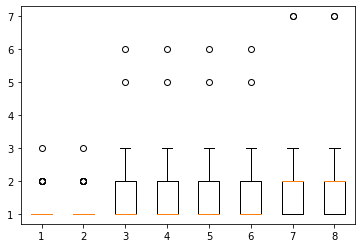

[{'n_neighbors': 3, 'weights': 'uniform'},
 {'n_neighbors': 3, 'weights': 'distance'},
 {'n_neighbors': 5, 'weights': 'uniform'},
 {'n_neighbors': 5, 'weights': 'distance'},
 {'n_neighbors': 7, 'weights': 'uniform'},
 {'n_neighbors': 7, 'weights': 'distance'},
 {'n_neighbors': 9, 'weights': 'uniform'},
 {'n_neighbors': 9, 'weights': 'distance'}]

In [ ]:
plt.boxplot(results)
plt.show()
list(ParameterGrid(parameters_knn))

Für SVM testen wir verschiedene Kernels, Regularization-Parameter C und Gamma.

In [ ]:
from sklearn.svm import SVC

parameters_svm = {'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [10**e for e in range(-1, 2)], 
                  'gamma': [0.001, 0.003]}
model_svm = ClassificationModel(SVC())

grid = GridSearchCV(model_svm, parameters_svm, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_svm = pd.DataFrame(grid.cv_results_)

results_svm[['param_C', 'param_gamma', 'param_kernel'] + important_results][results_svm['param_kernel'] != 'sigmoid'].sort_values('mean_test_detection_time', ascending=False)

{'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}


,param_C,param_gamma,param_kernel,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
17,10,0.003,rbf,1.000000,-4.104429,1.0,1.000000,1.0
11,1,0.003,rbf,1.000000,-6.533791,1.0,1.000000,1.0
14,10,0.001,rbf,1.000000,-7.010194,1.0,1.000000,1.0
5,0.1,0.003,rbf,0.996667,-8.284774,1.0,0.993590,1.0
8,1,0.001,rbf,0.996667,-8.412594,1.0,0.993590,1.0
13,10,0.001,poly,0.996667,-8.564662,1.0,0.993590,1.0
16,10,0.003,poly,0.996667,-8.823120,1.0,0.993590,1.0
10,1,0.003,poly,0.996667,-8.952068,1.0,0.993590,1.0
4,0.1,0.003,poly,0.996667,-8.957331,1.0,0.993590,1.0
7,1,0.001,poly,0.996667,-9.691353,1.0,0.993590,1.0


In [ ]:
from sklearn.svm import SVC

parameters_svm = {'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [10**e for e in range(-1, 2)], 
                  'gamma': [0.001, 0.003]}

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
parameters_idxs = {}
for idx, params in enumerate(tqdm(ParameterGrid(parameters_svm))):
  model_svm = ClassificationModel(SVC(**params))
  y_pred = model_svm.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))
  parameters_idxs[idx+1] = str(params)

100%|██████████| 18/18 [34:46<00:00, 115.90s/it]


In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(ParameterGrid(parameters_svm))):
    model_svm = ClassificationModel(SVC(**params))
    y_pred = model_svm.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


100%|██████████| 18/18 [34:43<00:00, 115.78s/it]


### 1


100%|██████████| 18/18 [36:19<00:00, 121.06s/it]


### 2


100%|██████████| 18/18 [35:07<00:00, 117.08s/it]


### 3


100%|██████████| 18/18 [37:00<00:00, 123.38s/it]


### 4


100%|██████████| 18/18 [33:53<00:00, 112.96s/it]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


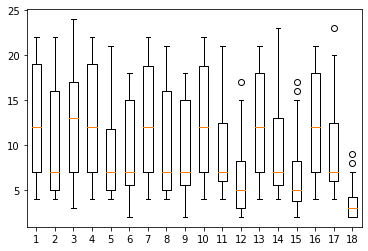

{1: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}",
 2: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}",
 3: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",
 4: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'linear'}",
 5: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'poly'}",
 6: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'rbf'}",
 7: "{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",
 8: "{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}",
 9: "{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",
 10: "{'C': 1, 'gamma': 0.003, 'kernel': 'linear'}",
 11: "{'C': 1, 'gamma': 0.003, 'kernel': 'poly'}",
 12: "{'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}",
 13: "{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",
 14: "{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",
 15: "{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",
 16: "{'C': 10, 'gamma': 0.003, 'kernel': 'linear'}",
 17: "{'C': 10, 'gamma': 0.003, 'kernel': 'poly'}",
 18: "{'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}"}

In [ ]:
plt.boxplot(results)
plt.show()
parameters_idxs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


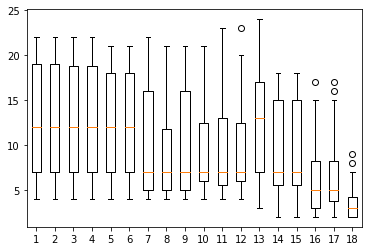

array([['1', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['4', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['7', "{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['10', "{'C': 1, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['13', "{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['16', "{'C': 10, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['2', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['5', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['8', "{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['11', "{'C': 1, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['14', "{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['17', "{'C': 10, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['3', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}"],
       ['6', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'rbf'}"],
       ['9', "{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}"],
       ['12', "{'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}"],
       ['

In [ ]:
r = np.array(results)
r = r[[0, 3, 6, 9, 12, 15, 1, 4, 7, 10, 13, 16, 2, 5, 8, 11, 14, 17]]
plt.boxplot(r)
plt.show()
np.array(list(parameters_idxs.items()))[[0, 3, 6, 9, 12, 15, 1, 4, 7, 10, 13, 16, 2, 5, 8, 11, 14, 17]]

Für MLP, also künstliche Neurale Netze, ist die Anzahl und Form der versteckten Layers mit entscheidend. Da hier nicht alle möglichen Kombinationen ausgetestet werden können, nutzen wir RandomizedSearchCV, welche keine erschöpfende Suche durch alle möglichen Parameterkombinationen, sondern nur eine zufällige Suche macht. Zwar wird hierdurch nicht das Optimum gefunden, aber wenigstens wird ein gutes gefunden (Runtime vs. Quality Tradeoff). Hierfür wird eine neue Klasse gebraucht, welche randomisierte Hidden-Layer-Shapes generiert.

In [ ]:
class NNSize(object):
    def __init__(self, shape_min=1, shape_max=3, size_min=5, size_max=24):
        self.shape_min = shape_min
        self.shape_max = shape_max
        self.size_min = size_min
        self.size_max = size_max

    def rvs(self, random_state=None):
        #np.random.seed(random_state)
        shape = np.random.randint(self.shape_min, self.shape_max+1)
        return tuple([np.random.randint(self.size_min, self.size_max+1) for _ in range(shape)])

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'hidden_layer_sizes': NNSize(), 
                  'learning_rate': ['constant', 'adaptive'], 
                  'activation': ['logistic', 'tanh', 'relu']}
model_mlp = ClassificationModel(MLPClassifier())

grid = RandomizedSearchCV(model_mlp, parameters_mlp, scoring=scoring, refit='detection_time', cv=4, verbose=3, n_iter=30)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_mlp = pd.DataFrame(grid.cv_results_)

results_mlp[['param_learning_rate', 'param_activation', 'param_hidden_layer_sizes'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'activation': 'logistic', 'hidden_layer_sizes': (23, 13), 'learning_rate': 'adaptive'}


,param_learning_rate,param_activation,param_hidden_layer_sizes,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
7,adaptive,logistic,"(23, 13)",1.000000,-7.441628,1.000000,1.000000,1.000000
25,constant,tanh,"(17,)",0.956667,-7.538756,0.936275,1.000000,0.912162
8,constant,logistic,"(17, 22)",1.000000,-8.315018,1.000000,1.000000,1.000000
5,adaptive,logistic,"(19, 7)",1.000000,-8.331145,1.000000,1.000000,1.000000
4,constant,logistic,"(10, 20)",0.996667,-8.782707,1.000000,0.993590,1.000000
13,adaptive,logistic,"(15, 16)",1.000000,-8.789392,1.000000,1.000000,1.000000
10,constant,logistic,"(13,)",1.000000,-9.238423,1.000000,1.000000,1.000000
0,constant,tanh,"(18,)",0.996667,-9.285526,1.000000,0.993590,1.000000
1,constant,relu,"(9, 15, 23)",0.980000,-9.399566,0.982143,0.980263,0.979167
2,adaptive,logistic,"(22, 24)",1.000000,-9.717597,1.000000,1.000000,1.000000


In [ ]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'learning_rate': ['constant', 'adaptive'], 
                  'activation': ['logistic', 'tanh', 'relu']}

In [ ]:
parameters_mlp_new = []
for params in ParameterGrid(parameters_mlp):
  for i in range(3):
    params2 = params.copy()
    params2['hidden_layer_sizes'] = NNSize().rvs()
    parameters_mlp_new.append(params2)

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
parameters_idxs = {}
for idx, params in enumerate(tqdm(parameters_mlp_new)):
  model_mlp = ClassificationModel(MLPClassifier(**params))
  y_pred = model_mlp.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))
  parameters_idxs[idx+1] = str(params)

 22%|██▏       | 4/18 [00:47<02:33, 10.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 33%|███▎      | 6/18 [01:14<02:26, 12.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 44%|████▍     | 8/18 [01:29<01:32,  9.21s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 94%|█████████▍| 17/18 [03:12<00:13, 13.65s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Sto

In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(parameters_mlp_new)):
    model_mlp = ClassificationModel(MLPClassifier(**params))
    y_pred = model_mlp.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


 22%|██▏       | 4/18 [00:58<03:27, 14.79s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [03:44<00:00, 12.48s/it]


### 1


 22%|██▏       | 4/18 [01:01<03:28, 14.93s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:50<00:00,  9.48s/it]


### 2


 22%|██▏       | 4/18 [01:01<03:36, 15.44s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 33%|███▎      | 6/18 [01:30<02:57, 14.77s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [03:06<00:00, 10.34s/it]


### 3


 22%|██▏       | 4/18 [00:42<02:08,  9.18s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:25<00:00,  8.06s/it]


### 4


 22%|██▏       | 4/18 [00:51<02:54, 12.47s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 72%|███████▏  | 13/18 [01:51<00:28,  5.67s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:49<00:00,  9.43s/it]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


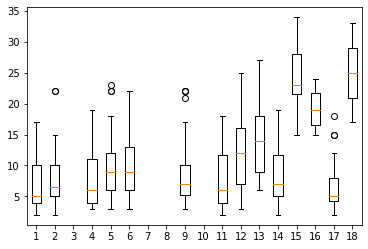

{1: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (13, 17, 13)}",
 2: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (24, 24)}",
 3: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (11, 11, 17)}",
 4: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (22, 15, 5)}",
 5: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,)}",
 6: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (9, 14, 24)}",
 7: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (12,)}",
 8: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (22, 15)}",
 9: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (18,)}",
 10: "{'activation': 'tanh', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13, 14)}",
 11: "{'activation': 'tanh', 'learning_rate': 'adaptive', 'h

In [ ]:
plt.boxplot(results)
plt.show()
parameters_idxs

### Feature Extraction

Nun testen wir transformierte Daten aus.
Zuerst das inkludieren der 'letzten' Tage für jeden Datenpunkt.
Als Algorithmus nehmen wir das beste aus den Ergebnissen der Grid-Search: KNN.

In [ ]:
# Transform X
X_transform = past_days_transform(X, wdn.important_nodes)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

Nun testen wir verschiedene Transformationsparameter.

In [ ]:
from sklearn.model_selection import ParameterGrid

node_selections = [['10', '11', '12', '13', '21', '22', '23', '31', '32'],
                   ['11', '12', '13', '21', '22', '23'],
                   ['11', '12', '13', '22'],
                   ['12']]
param_grid = {'nodes': node_selections, 'past_end': [1, 2, 3, 4, 5]}

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

result_list = []

for params in tqdm(ParameterGrid(param_grid)):
  X_transform = past_days_transform(X, **params)
  
  model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)
  
  cv_results = pd.DataFrame(cross_validate(model, X_transform, y, cv=5, scoring=scoring))
  res = pd.concat([pd.Series(params), cv_results.mean()])
  result_list.append(res)

results_fe = pd.DataFrame(result_list)

100%|██████████| 20/20 [06:16<00:00, 18.81s/it]


In [ ]:
results_fe.sort_values('test_detection_time', ascending=False)

,nodes,past_end,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time
11,"[11, 12, 13, 22]",2,0.111996,1.035425,1.0,1.0,1.0,1.0,-1.372893
6,"[11, 12, 13, 21, 22, 23]",2,0.063903,4.876664,1.0,1.0,1.0,1.0,-1.393229
0,"[10, 11, 12, 13, 21, 22, 23, 31, 32]",1,0.073002,0.830102,1.0,1.0,1.0,1.0,-1.401031
5,"[11, 12, 13, 21, 22, 23]",1,0.132040,0.836736,1.0,1.0,1.0,1.0,-1.401031
15,[12],1,0.079037,0.790884,1.0,1.0,1.0,1.0,-1.401031
10,"[11, 12, 13, 22]",1,0.080462,0.807372,1.0,1.0,1.0,1.0,-1.401031
1,"[10, 11, 12, 13, 21, 22, 23, 31, 32]",2,0.063604,4.912503,1.0,1.0,1.0,1.0,-1.434444
12,"[11, 12, 13, 22]",3,0.072397,4.890392,1.0,1.0,1.0,1.0,-1.444128
7,"[11, 12, 13, 21, 22, 23]",3,0.079328,4.953763,1.0,1.0,1.0,1.0,-1.464791
16,[12],2,0.092404,0.878823,1.0,1.0,1.0,1.0,-1.469680


## Regression

### Testing Ensamble

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({1: 551, 0: 199})
Counter({1: 183, 0: 67})


In [ ]:
from sklearn.linear_model import LinearRegression

# Create the model
model = RegressionEnsamble(LinearRegression(), th_model=8, medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train, verbose=True)

# Predict on the test subset
#y_pred = model.predict(X_test)

# Show results
#print_metrics(y_test, y_pred)

100%|██████████| 9/9 [00:48<00:00,  5.41s/it]


RegressionEnsamble(copy_X=True, fit_intercept=True, model=LinearRegression(),
                   n_jobs=None, normalize='deprecated', positive=False,
                   th_model=8)

In [ ]:
for i in range(len(wdn.important_nodes)):
  print('##### th_model_override =', i)
  y_pred = model.predict(X_test, th_model_override=i)
  print_metrics(y_test, y_pred)

##### th_model_override = 0
[[ 67   0]
 [ 71 112]]
Accuracy:     0.716	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.612	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 632.893ts	Std: 2145.372ts	Median: 0.0ts
##### th_model_override = 1
[[67  0]
 [88 95]]
Accuracy:     0.648	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.519	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 611.884ts	Std: 2194.714ts	Median: 0.0ts
##### th_model_override = 2
[[ 67   0]
 [126  57]]
Accuracy:     0.496	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.311	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 -> Mean: nants	Std: nants	Median: nants
##### th_model_override = 7
[[ 67   0]
 [183   0]]
Accuracy:     0.268	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 -> Mean: nants	Std: nants	Median: nants
##### th_model_override = 8
[[ 67   0]
 [183   0]]
Accuracy:     0.268	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 -> Mean: nants	Std: nants	Median: nants


Jetzt mit th_model=KNN

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = RegressionEnsamble(LinearRegression(), th_model=KNeighborsClassifier(), medfilt_kernel_size=11)

# Learn on the train subset
model.fit(X_train, y_train, verbose=True)

# Predict on the test subset
y_pred = model.predict(X_test, verbose=True)

# Show results
print_metrics(y_test, y_pred)

100%|██████████| 9/9 [00:35<00:00,  3.91s/it]


Training threshold classifier...


100%|██████████| 250/250 [40:13<00:00,  9.65s/it]


[[ 34  33]
 [  3 180]]
Accuracy:     0.856	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.984	Wie gut wurden echte Lecks erkannt?
Specificity:  0.507	Wie gut wurde 'alles ok' erkannt?
Precision:    0.845	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 86.14ts	Std: 836.848ts	Median: 0.0ts


Jetzt was anderes

In [ ]:
y_concat = np.concatenate(y_train)

In [ ]:
t = abs(diff[y_concat == 0]).max()

In [ ]:
t

10    11.355816
11     5.299861
12     4.216727
13     2.303621
21     4.147227
22     1.000316
23     1.182825
31     5.077840
32     6.588341
dtype: float64

In [ ]:
diff.iloc[0]

10    0.599529
11   -0.059544
12    0.045979
13   -0.072730
21   -0.116164
22    0.003398
23    0.012244
31   -0.037145
32    0.132453
Name: 0, dtype: float64

In [ ]:
sum(diff.iloc[0] + 2 > t)

2

In [ ]:
Counter(((diff > t).sum(axis=1) > 0).astype(int))

Counter({0: 11802173, 1: 977827})

In [ ]:
diff_noleak = diff[y_concat == 0]
diff_leak   = diff[y_concat == 1]

In [ ]:
round(diff_noleak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000
std,0.9518,0.5761,0.2301,0.1719,0.1568,0.0540,0.0565,0.2907,0.3135
min,-11.3558,-4.1837,-2.3101,-1.6185,-1.0910,-0.8915,-1.1828,-1.7885,-6.5883
25%,-0.5266,-0.2759,-0.1101,-0.0817,-0.0735,-0.0241,-0.0180,-0.1364,-0.0945
50%,-0.0727,-0.0437,-0.0188,-0.0053,-0.0168,-0.0046,0.0071,-0.0149,0.0381
75%,0.4036,0.2150,0.0845,0.0675,0.0357,0.0177,0.0286,0.1094,0.1593
max,9.3895,5.2999,4.2167,2.3036,4.1472,1.0003,0.5166,5.0778,1.6663


In [ ]:
round(diff_leak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,1.0000,0.7446,0.6773,0.0945,-0.3997,0.6997,-0.7616,1.1826,-1.6511
std,11.5898,3.0227,5.3870,6.5629,3.9593,3.1099,3.7145,10.0540,12.2949
min,-70.5752,-33.4514,-8.4629,-76.6800,-59.5974,-13.2872,-70.1262,-68.8362,-82.7597
25%,-3.2232,-0.5544,-1.1443,-0.0540,-0.5491,-0.1926,-0.0722,-0.2727,-0.1339
50%,-0.2435,0.0883,-0.1550,0.1042,-0.0032,-0.0103,0.0326,0.0693,0.2572
75%,2.1544,1.6106,0.2250,0.4655,0.7892,0.2553,0.2376,1.1267,1.2446
max,161.1756,28.1722,69.8410,80.4532,43.3055,59.7316,6.5538,62.7622,57.9750


In [ ]:
diff_abs = abs(diff)
diff_abs_noleak = diff_abs[y_concat == 0]
diff_abs_leak   = diff_abs[y_concat == 1]

In [ ]:
round(diff_abs_noleak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,0.6727,0.3867,0.1551,0.1167,0.0963,0.0347,0.0372,0.1928,0.2028
std,0.6734,0.4270,0.1700,0.1263,0.1238,0.0413,0.0425,0.2176,0.2390
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1828,0.1049,0.0414,0.0294,0.0228,0.0089,0.0106,0.0503,0.0570
50%,0.4739,0.2488,0.0992,0.0750,0.0581,0.0214,0.0243,0.1235,0.1326
75%,0.9452,0.5178,0.2091,0.1615,0.1232,0.0458,0.0498,0.2644,0.2702
max,11.3558,5.2999,4.2167,2.3036,4.1472,1.0003,1.1828,5.0778,6.5883


In [ ]:
round(diff_abs_leak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,6.4877,1.8472,2.1240,2.3413,1.8853,1.1044,1.1222,4.2791,4.7538
std,9.6558,2.5058,4.9967,6.1318,3.5046,2.9903,3.6219,9.1745,11.4582
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.7295,0.3176,0.1778,0.0806,0.1127,0.0461,0.0453,0.1589,0.2157
50%,2.8580,0.9583,0.7890,0.2548,0.7164,0.2146,0.1694,0.5299,0.7737
75%,9.3673,2.4118,1.9545,0.8717,2.0638,0.7520,0.5039,2.8713,2.4494
max,161.1756,33.4514,69.8410,80.4532,59.5974,59.7316,70.1262,68.8362,82.7597


Ab hier Net1 Sim

In [ ]:
round(diff_noleak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
std,0.7505,0.3379,0.3759,0.3326,0.3238,0.3261,0.3298,0.3684,0.3831
min,-2.9020,-1.6337,-1.5096,-1.2581,-1.1817,-1.3090,-1.3990,-1.3476,-1.5658
25%,-0.5035,-0.2303,-0.2542,-0.2214,-0.2185,-0.2202,-0.2243,-0.2492,-0.2591
50%,0.0112,0.0006,-0.0027,0.0002,0.0009,-0.0013,0.0024,0.0039,0.0018
75%,0.5037,0.2275,0.2493,0.2253,0.2171,0.2233,0.2210,0.2476,0.2544
max,3.5446,1.2822,1.4408,1.3899,1.2553,1.2570,1.2224,1.5543,1.5194


In [ ]:
round(diff_leak.describe(), 4).drop('count')

,10,11,12,13,21,22,23,31,32
mean,0.0439,0.0131,-0.1912,-0.0934,0.0766,-0.1058,-0.1071,0.1844,0.1109
std,0.7638,0.3439,0.4807,0.3664,0.3399,0.3594,0.3551,0.4643,0.4448
min,-2.8096,-1.2737,-1.7242,-1.3410,-0.9959,-1.2839,-1.4056,-1.3115,-1.6654
25%,-0.4567,-0.2127,-0.5244,-0.3337,-0.1549,-0.3427,-0.3464,-0.1302,-0.1933
50%,0.0474,0.0127,-0.1897,-0.1039,0.0709,-0.1064,-0.1033,0.1810,0.1158
75%,0.5553,0.2407,0.1290,0.1510,0.3076,0.1319,0.1373,0.5026,0.4154
max,2.8208,1.3850,1.6332,1.2195,1.4485,1.0649,1.0015,1.7773,1.6420


In [ ]:
model = RegressionModel(LinearRegression())
model.fit(X_train, y_train)
model.threshold

-1.4122064008077473

In [ ]:
pr = model.predict(X_test)
Counter(any_transform(pr, pr)[0])

Counter({0: 71, 1: 4})

In [ ]:
print_metrics(y_test, pr)

[[43  0]
 [28  4]]
Accuracy:     0.627	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.125	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Mean Detection Time: -11.0h	Wie viele Stunden dauerte es bis zum erkennen?


In [ ]:
X_concat = pd.concat(X)
X_concat.reset_index(drop=True, inplace=True)
y_concat = np.concatenate(y)

In [ ]:
data_regr = X_concat[y_concat == 0]
X_regr = data_regr[['10', '11','13','21','22','23','31','32']]
y_regr = data_regr['12']

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_regr, y_regr)
reg.score(X_regr, y_regr)

pred = reg.predict(X[0][['10', '11','13','21','22','23','31','32']])

In [ ]:
pred

array([82.433, 81.123, 79.535, 80.181, 80.854, 80.901, 81.489, 81.352, 81.705, 82.25 , 82.599, 83.453, 83.984, 85.018, 85.966, 86.667, 87.774, 87.551, 86.944, 86.527, 85.976, 85.206, 84.184, 83.026, 81.997, 80.863, 79.354, 80.336, 80.326, 81.093, 80.995, 81.416, 82.041, 82.219, 82.734, 83.608,
       84.209, 84.711, 85.969, 86.776, 88.024, 87.413, 86.717, 86.5  , 86.177, 85.094, 84.52 , 83.446, 82.055, 81.082, 79.373, 80.346, 80.416, 81.151, 81.19 , 81.278, 81.85 , 81.698, 82.83 , 83.661, 84.364, 84.905, 85.883, 86.861, 88.133, 87.653, 87.125, 86.758, 85.943, 85.099, 83.955, 83.718,
       81.974, 80.791, 79.799, 80.139, 80.299, 80.749, 80.067, 79.799, 79.435, 79.75 , 79.511, 79.286, 79.617, 80.326, 80.979, 81.087, 81.679, 82.638, 83.269, 84.6  , 85.46 , 85.739, 86.178, 86.442, 87.22 , 87.43 , 87.093, 87.253, 86.952, 86.617, 86.362, 85.358, 85.168, 84.947, 84.8  , 84.587,
       85.027, 84.789, 85.34 , 85.787, 86.355, 86.945, 87.674, 88.055, 87.034, 85.176, 83.911, 82.42 , 80.423])

In [ ]:
X[0]['12']

0      82.169335
1      80.904409
2      79.379129
3      80.255046
4      80.922121
         ...    
116    86.738197
117    85.309073
118    84.209008
119    82.464307
120    80.699488
Name: 12, Length: 121, dtype: float64

In [ ]:
r = pd.DataFrame(X[0]['12'] - pred)

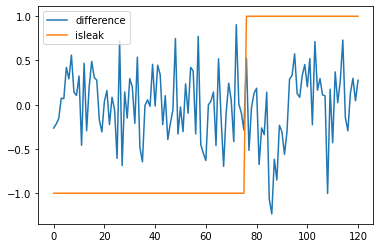

In [ ]:
for_vis = r.copy()[['12']]
for_vis['isleak'] = (y[0] - 0.5) * 2
for_vis.columns = 'difference', 'isleak'
for_vis.plot()

In [ ]:
r['hour of the day'] = X[0]['hour of the day']

In [ ]:
r

,12,hour of the day
0,-0.263444,0
1,-0.218436,1
2,-0.156202,2
3,0.074539,3
4,0.068125,4
...,...,...
116,-0.295818,20
117,0.132790,21
118,0.298192,22
119,0.044563,23


In [ ]:
res_noleak = {}
res_leak   = {}
for i in range(24):
  r_noleak = r[y[0] == 0]
  r_leak   = r[y[0] == 1]
  res_noleak[i] = np.array(r_noleak[r_noleak['hour of the day'] == i]['12']).mean()
  res_leak[i]   = np.array(r_leak[r_leak['hour of the day'] == i]['12']).mean()

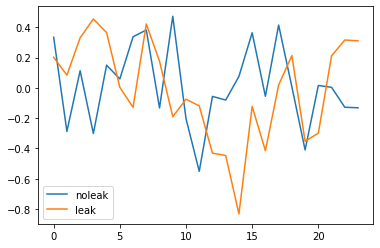

In [ ]:
pd.DataFrame({'noleak': pd.Series(res_noleak), 'leak': pd.Series(res_leak)}).plot()

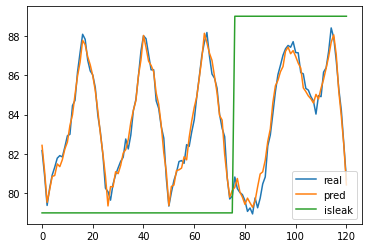

In [ ]:
vals = pd.DataFrame({'real': X[0]['12'], 'pred': pred, 'isleak': 79+10*y[0]})
vals.plot()

In [ ]:
r_noleak = r[y[0] == 0]
r_leak   = r[y[0] == 1]

In [ ]:
threshold = r_noleak.min()[0]#(r_noleak.min()[0] + r_leak.min()[0]) / 2

In [ ]:
threshold

-0.6961727550108492

In [ ]:
test_y_true = y[0] == 1

In [ ]:
from scipy.signal import medfilt
test_y_pred = np.array((r < threshold)['12'])

In [ ]:
test_y_pred

array([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
print(confusion_matrix(test_y_true, test_y_pred))
print('accuracy', accuracy_score(test_y_true, test_y_pred))
print('recall', recall_score(test_y_true, test_y_pred))
print('specificity', recall_score(test_y_true, test_y_pred, pos_label=0))
print('precision', precision_score(test_y_true, test_y_pred))

[[76  0]
 [41  4]]
accuracy 0.6611570247933884
recall 0.08888888888888889
specificity 1.0
precision 1.0


In [ ]:
r_noleak.describe()

,12,hour of the day
count,76.000000,76.000000
mean,0.013486,10.973684
std,0.370008,7.149776
min,-0.696173,0.000000
25%,-0.234698,4.750000
50%,0.001777,11.000000
75%,0.280220,17.000000
max,0.905014,23.000000


In [ ]:
r_noleak.quantile(.0)['12']

-0.6961727550108492

In [ ]:
r_leak.describe()

,12
count,45.000000
mean,-0.032967
std,0.468424
min,-1.233714
25%,-0.301617
50%,0.111816
75%,0.289087
max,0.731154


In [ ]:
X_concat = pd.concat(X)
X_concat.reset_index(drop=True, inplace=True)
y_concat = np.concatenate(y)

X_regr = X_concat[['10', '11','13','21','22','23','31','32']]
y_regr = X_concat['12']

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_regr, y_regr)
reg.score(X_regr, y_regr)

pred_all = reg.predict(X_regr)

In [ ]:
r_all = pd.DataFrame(y_regr - pred_all)

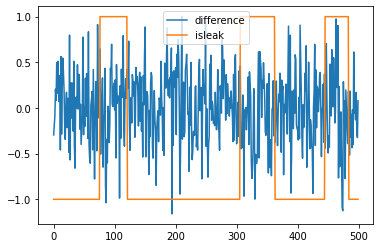

In [ ]:
for_vis_all = r_all.copy()[['12']]
for_vis_all['isleak'] = (y_concat - 0.5) * 2
for_vis_all.columns = 'difference', 'isleak'
for_vis_all[:500].plot()

In [ ]:
r_all['hour of the day'] = X_concat['hour of the day']

In [ ]:
res_noleak_all = {}
res_leak_all   = {}
for i in range(24):
  r_noleak = r_all[y_concat == 0]
  r_leak   = r_all[y_concat == 1]
  res_noleak_all[i] = np.array(r_noleak[r_noleak['hour of the day'] == i]['12'])
  res_leak_all[i]   = np.array(r_leak[r_leak['hour of the day'] == i]['12'])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


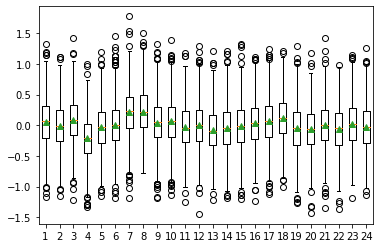

In [ ]:
plt.boxplot(list(res_noleak_all.values()), showmeans=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


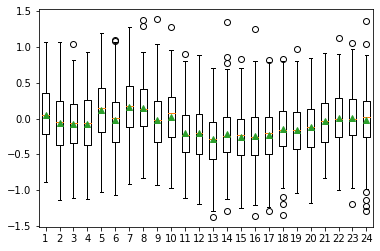

In [ ]:
plt.boxplot(list(res_leak_all.values()), showmeans=True)
plt.show()

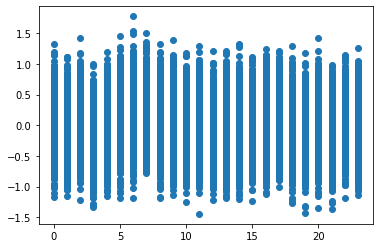

In [ ]:
scatter_X = []
scatter_y = []
for e in res_noleak_all:
  scatter_X.append(np.zeros(len(res_noleak_all[e])) + e)
  scatter_y.append(res_noleak_all[e])
scatter_X = np.concatenate(scatter_X)
scatter_y = np.concatenate(scatter_y)

plt.scatter(scatter_X, scatter_y)
plt.show()

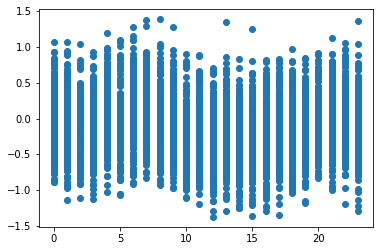

In [ ]:
scatter_X = []
scatter_y = []
for e in res_leak_all:
  scatter_X.append(np.zeros(len(res_leak_all[e])) + e)
  scatter_y.append(res_leak_all[e])
scatter_X = np.concatenate(scatter_X)
scatter_y = np.concatenate(scatter_y)

plt.scatter(scatter_X, scatter_y)
plt.show()

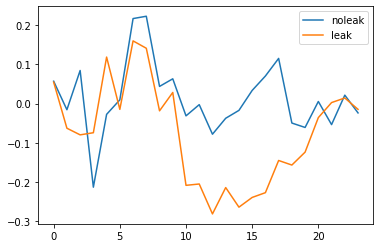

In [ ]:
pd.DataFrame({'noleak': pd.Series(res_noleak_all), 'leak': pd.Series(res_leak_all)}).plot()

## Outlier Detection

### Der Train-Test-Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({1: 549, 0: 201})
Counter({1: 185, 0: 65})


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

clf_svm = OutlierDetectionModel(OneClassSVM(), 5)
clf_iso = OutlierDetectionModel(IsolationForest(), 5)

pred_svm = clf_svm.fit(X_train).predict(X_test)
pred_iso = clf_iso.fit(X_train).predict(X_test)

print('#### OneClassSVM')
print_metrics(y_test, pred_svm)
print('#### IsolationForest')
print_metrics(y_test, pred_iso)

#### OneClassSVM
[[ 0 65]
 [ 0 85]]
Accuracy:     0.567	Wie oft lag der Algorithmus richtig?
Recall (Sns): 1.0	Wie gut wurden echte Lecks erkannt?
Specificity:  0.0	Wie gut wurde 'alles ok' erkannt?
Precision:    0.567	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Stunden dauerte es bis zum erkennen?
 -> Mean: 2.024h	Std: 3.332h	Median: 0.0h
#### IsolationForest
[[60  5]
 [ 1 84]]
Accuracy:     0.96	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.988	Wie gut wurden echte Lecks erkannt?
Specificity:  0.923	Wie gut wurde 'alles ok' erkannt?
Precision:    0.944	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Stunden dauerte es bis zum erkennen?
 -> Mean: 5.5h	Std: 5.622h	Median: 4.0h


#### LeakDB

In [ ]:
#from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

#clf_svm = OutlierDetectionModel(OneClassSVM(), 5)
clf_iso = OutlierDetectionModel(IsolationForest(), 11)

#pred_svm = clf_svm.fit(X_train).predict(X_test)
pred_iso = clf_iso.fit(X_train).predict(X_test)

#print('#### OneClassSVM')
#print_metrics(y_test, pred_svm)
print('#### IsolationForest')
print_metrics(y_test, pred_iso)

#### IsolationForest
[[  1  64]
 [  0 185]]
Accuracy:     0.744	Wie oft lag der Algorithmus richtig?
Recall (Sns): 1.0	Wie gut wurden echte Lecks erkannt?
Specificity:  0.015	Wie gut wurde 'alles ok' erkannt?
Precision:    0.743	Wie viele erkannte lecks waren auch wirklich Lecks?
Detection Time      	Wie viele Zeiteinheiten dauerte es bis zum erkennen?
 -> Mean: 410.848ts	Std: 1952.307ts	Median: 0.0ts


### Das Cross-Validation

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import IsolationForest
from utils.metrics import accuracy, recall, specificity, precision, detection_time_mean, detection_time_std, detection_time_median
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time_mean': make_scorer(detection_time_mean),
           'detection_time_std': make_scorer(detection_time_std),
           'detection_time_median': make_scorer(detection_time_median)}

model = OutlierDetectionModel(IsolationForest(), medfilt_kernel_size=5)

cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)
round(pd.DataFrame(cv_results), 2)

,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time_mean,test_detection_time_std,test_detection_time_median
0,0.98,5.97,1.00,1.00,1.00,1.00,4.53,5.98,1.5
1,0.76,3.42,0.97,0.94,1.00,1.00,6.65,7.82,3.0
2,0.71,3.35,0.97,0.92,1.00,1.00,4.92,5.23,3.5
3,0.72,3.45,1.00,1.00,1.00,1.00,6.19,6.21,5.0
4,0.74,3.54,0.92,0.97,0.85,0.89,2.41,2.82,1.5
5,0.72,3.48,1.00,1.00,1.00,1.00,3.59,4.58,1.5
6,0.71,3.42,0.97,1.00,0.94,0.94,2.76,4.07,1.0
7,0.68,3.49,0.95,0.90,1.00,1.00,5.89,6.81,2.0
8,0.71,3.43,0.98,0.97,1.00,1.00,3.10,4.21,1.0
9,0.71,3.50,1.00,1.00,1.00,1.00,4.62,7.74,1.5


In [ ]:
round(pd.DataFrame(cv_results), 2).mean()

fit_time                      0.744
score_time                    3.705
test_accuracy                 0.976
test_recall                   0.970
test_specificity              0.979
test_precision                0.983
test_detection_time_mean      4.466
test_detection_time_std       5.547
test_detection_time_median    2.150
dtype: float64

### Das Grid-Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time_mean, detection_time_std, detection_time_median
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time_mean': make_scorer(detection_time_mean),
           'detection_time_std': make_scorer(detection_time_std),
           'detection_time_median': make_scorer(detection_time_median)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time_mean', 
                     'mean_test_detection_time_std', 'mean_test_detection_time_median',
                     'mean_test_precision', 'mean_test_recall', 'mean_test_specificity']

In [ ]:
from sklearn.ensemble import IsolationForest

parameters_iso = {'n_estimators': [100+25*i for i in range(9)], 'bootstrap': [True, False]}
model_iso = OutlierDetectionModel(IsolationForest())

grid = GridSearchCV(model_iso, parameters_iso, scoring=scoring, refit='detection_time_mean', cv=4, verbose=3)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_iso = pd.DataFrame(grid.cv_results_)

round(results_iso[['param_n_estimators', 'param_bootstrap'] + important_results].sort_values('mean_test_accuracy', ascending=False), 3)

{'bootstrap': True, 'n_estimators': 125}


,param_n_estimators,param_bootstrap,mean_test_accuracy,mean_test_detection_time_mean,mean_test_detection_time_std,mean_test_detection_time_median,mean_test_precision,mean_test_recall,mean_test_specificity
12,175,False,0.988,4.926,6.477,1.625,1.000,0.975,1.000
17,300,False,0.987,4.672,6.141,1.500,1.000,0.972,1.000
3,175,True,0.987,4.389,5.892,1.500,1.000,0.973,1.000
6,250,True,0.987,4.546,6.259,1.250,1.000,0.972,1.000
2,150,True,0.987,5.006,6.706,1.750,0.997,0.975,0.997
8,300,True,0.985,4.494,6.435,1.250,1.000,0.969,1.000
16,275,False,0.985,4.644,6.239,1.750,1.000,0.968,1.000
14,225,False,0.985,4.394,5.924,1.500,1.000,0.969,1.000
4,200,True,0.983,3.876,5.268,1.125,0.994,0.972,0.993
15,250,False,0.982,4.445,6.028,1.625,0.993,0.970,0.994
